In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import math
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import datetime
import time
import random
from PIL import Image
import pickle
import joblib
import re

from sklearn import preprocessing
import tensorflow as tf
from keras.layers import Input,Dense,LSTM,Flatten,Dropout,concatenate,Conv1D,MaxPooling2D,Activation
from keras.layers import BatchNormalization
from keras.layers import Embedding
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# import keras_tuner
from tensorflow import keras
import tensorflow_hub as hub
import imgaug.augmenters as iaa
from tensorflow.keras.preprocessing import image, text, sequence
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np

import warnings
warnings.filterwarnings("ignore")

## 1. Final Pipeline

In [ ]:
colab_path = "/content/drive/MyDrive/Applied AI/"
tokenizer_50k = pickle.load(open('/content/drive/MyDrive/Applied AI/CS2/model/tokenizer_50k.pkl', 'rb'))
model = pickle.load(open('/content/drive/MyDrive/Applied AI/CS2/model/final_model.pkl', 'rb'))
labelencoder = pickle.load(open('/content/drive/MyDrive/Applied AI/CS2/model/labelencoder.pkl', 'rb'))

def final_function_1(X): # X = [que_text,image_path]

  que_clean_text = text_preprocess(X[0])
  que_vector = pad_sequences(tokenizer_50k.texts_to_sequences([que_clean_text]), maxlen=22, padding='post') 
  
  img = cv2.imread(os.path.join(colab_path,X[1]))
  img = cv2.resize(img,(224,224),interpolation=cv2.INTER_NEAREST)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_vector = (img/255.0).astype(np.float32)

  predicted_Y = model.predict([que_vector,np.array([img_vector])],verbose=0)
  predicted_class = tf.argmax(predicted_Y, axis=1, output_type=tf.int32)
  predicted_ans = labelencoder.inverse_transform(predicted_class)

  return predicted_ans[0], predicted_Y[0][int(predicted_class)]

def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)
    
    phrase = re.sub(r"he\'s", "he is", phrase)
    phrase = re.sub(r"she\'s", "she is", phrase)
    phrase = re.sub(r"it\'s", "it is", phrase)
    
    phrase = re.sub(r"he\’s", "he is", phrase)
    phrase = re.sub(r"she\’s", "she is", phrase)
    phrase = re.sub(r"it\’s", "it is", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def text_preprocess(text):
    text = text.lower()
    text = decontractions(text) # replace contractions into natural form
    text = re.sub('[-,:]', ' ', text) # replace the character "-" "," with space
    text = re.sub("(?!<=\d)(\.)(?!\d)", '', text) # remove the character ".", except from floating numbers
    text = re.sub('[^A-Za-z0-9. ]+', '', text) # remove all punctuation, except A-Za-z0-9 
    text = re.sub(' +', ' ', text) # remove extra space
    return text

def text_preprocess_ans(text):
    text = text.lower()
    text = decontractions(text) # replace contractions into natural form
    text = re.sub('[-,:]', ' ', text) # replace the character "-" "," with space
    text = re.sub("(?!<=\d)(\.)(?!\d)", '', text) # remove the character ".", except from floating numbers
    text = re.sub('[^A-Za-z0-9.! ]+', '', text) # remove all punctuation, except A-Za-z0-9 
    text = re.sub(' +', ' ', text) # remove extra space
    return text

Input: ['what color is the building', 'train2014/COCO_train2014_000000084193.jpg']


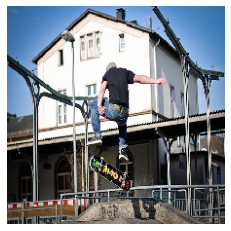

Actual Answer: white
Predicted Answer: white
Predicted Probability: 0.21926826


In [ ]:
X = [list(X_test['question_preprocessed'])[5], list(X_test['image_id'])[5]]
print("Input:",X)
img = cv2.imread(colab_path+X[1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img); plt.axis('off'); plt.show()
print("Actual Answer:",labelencoder.inverse_transform([list(y_test)[5]])[0])
predicted_ans, prob_ans = final_function_1(X)
print("Predicted Answer:",predicted_ans)
print("Predicted Probability:",prob_ans)

Input: ['what is on the wall behind the toilet', 'train2014/COCO_train2014_000000018751.jpg']


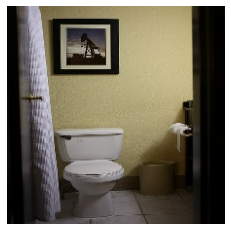

Actual Answer: picture
Predicted Answer: picture
Predicted Probability: 0.12025659


In [ ]:
X = [list(X_test['question_preprocessed'])[7], list(X_test['image_id'])[7]]
print("Input:",X)
img = cv2.imread(colab_path+X[1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img); plt.axis('off'); plt.show()
print("Actual Answer:",labelencoder.inverse_transform([list(y_test)[7]])[0])
predicted_ans, prob_ans = final_function_1(X)
print("Predicted Answer:",predicted_ans)
print("Predicted Probability:",prob_ans)

Input: ['what color is the bike', 'train2014/COCO_train2014_000000060378.jpg']


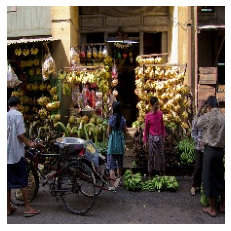

Actual Answer: black
Predicted Answer: white
Predicted Probability: 0.19367564


In [ ]:
X = [list(X_test['question_preprocessed'])[0], list(X_test['image_id'])[0]]
print("Input:",X)
img = cv2.imread(colab_path+X[1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img); plt.axis('off'); plt.show()
print("Actual Answer:",labelencoder.inverse_transform([list(y_test)[0]])[0])
predicted_ans, prob_ans = final_function_1(X)
print("Predicted Answer:",predicted_ans)
print("Predicted Probability:",prob_ans)

Input: ['What cOlor is the  - bike??', 'train2014/COCO_train2014_000000060378.jpg']


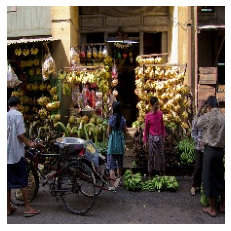

Actual Answer: black
Predicted Answer: white
Predicted Probability: 0.19367564


In [ ]:
X = ['What cOlor is the  - bike??', 'train2014/COCO_train2014_000000060378.jpg']
print("Input:",X)
img = cv2.imread(colab_path+X[1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img); plt.axis('off'); plt.show()
print("Actual Answer:",labelencoder.inverse_transform([list(y_test)[0]])[0])
predicted_ans, prob_ans = final_function_1(X)
print("Predicted Answer:",predicted_ans)
print("Predicted Probability:",prob_ans)

In [ ]:
def final_function_2(X,Y): # X & Y is an unseen dataset
  
  predicted_ans = []
  for i in tqdm(range(len(X))):
    pred_ans, pred_prob = final_function_1([list(X['question_preprocessed'])[i], list(X['image_id'])[i]])
    predicted_ans.append(pred_ans)

  acc_val_lst = []
  for i in tqdm(range(len(Y))):
    acc_val = 0.0
    temp = 0
  
    for actual_ans in (list(X['answers'])[i]).split(","):
      if actual_ans == predicted_ans[i]:
        temp += 1
      
    if temp >= 3:
      acc_val = 1
    else:
      acc_val = float(temp)/3
  
    acc_val_lst.append(acc_val)
  
  accuracy = (sum(acc_val_lst)/len(Y))*100

  return accuracy, acc_val_lst

In [ ]:
Train_accuracy, Train_accuracy_lst = final_function_2(X_train,y_train)
print("\nTrain Accuracy:",Train_accuracy) 
pickle.dump((Train_accuracy,Train_accuracy_lst),open('/content/drive/MyDrive/Applied AI/CS2/model/Train_Results.pkl','wb'))

100%|██████████| 40503/40503 [01:40<00:00, 403.20it/s]


Train Accuracy: 49.69919923627049


In [ ]:
Val_accuracy, val_accuracy_lst = final_function_2(X_val,y_val)
print("\nValidation Accuracy:",Val_accuracy) 
pickle.dump((Val_accuracy,val_accuracy_lst),open('/content/drive/MyDrive/Applied AI/CS2/model/Val_Results.pkl','wb'))

100%|██████████| 5001/5001 [00:01<00:00, 3514.36it/s]


Validation Accuracy: 44.251149770045956


In [ ]:
Test_accuracy, test_accuracy_lst = final_function_2(X_test,y_test)
print("\nTest Accuracy:",Test_accuracy) 
pickle.dump((Test_accuracy,test_accuracy_lst),open('/content/drive/MyDrive/Applied AI/CS2/model/Test_Results.pkl','wb'))

100%|██████████| 4501/4501 [00:01<00:00, 3892.21it/s]


Test Accuracy: 44.24202029178688


In [ ]:
print("Train Accuracy:",round(Train_accuracy,3)) 
print("Validation Accuracy:",round(Val_accuracy,3))
print("Test Accuracy:",round(Test_accuracy,3)) 

Train Accuracy: 49.699
Validation Accuracy: 44.251
Test Accuracy: 44.242


In [ ]:
from prettytable import PrettyTable
x2 = PrettyTable(["Model", "Datapoints", "Class Labels", "Sampled Datapoints", "Epochs", "Train Accuracy", "Validation Accuracy", "Test Accuracy"])
x2.add_row(["LSTM+VGG19", "380554", "1000", "50000", "50", round(Train_accuracy,3), round(Val_accuracy,3), round(Test_accuracy,3)])
print(x2)

+------------+------------+--------------+--------------------+--------+----------------+---------------------+---------------+
|   Model    | Datapoints | Class Labels | Sampled Datapoints | Epochs | Train Accuracy | Validation Accuracy | Test Accuracy |
+------------+------------+--------------+--------------------+--------+----------------+---------------------+---------------+
| LSTM+VGG19 |   380554   |     1000     |       50000        |   50   |     49.699     |        44.251       |     44.242    |
+------------+------------+--------------+--------------------+--------+----------------+---------------------+---------------+
